In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import shap
import time
from numpy import concatenate
Scaler = MinMaxScaler()

# Load training dataset

In [2]:
# Load training dataset
os.chdir('..\\Algal-bloom-prediction-machine-learning\\Trainning data')
file_name = input('file name of observation dataset:')
all_df = pd.read_csv(file_name,sep = ',',parse_dates = ['Date'])

file name of observation dataset:ME_Observation_df.csv


In [3]:
# Specify the training year
n_trainingyr = int(input('Number of training years:'))
year = []
for i in range(n_trainingyr):
    y=int(input('Year:'))
    year.append(y)
# Lake Erken: [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 

Number of training years:11
Year:1999
Year:2000
Year:2001
Year:2002
Year:2003
Year:2004
Year:2005
Year:2006
Year:2007
Year:2008
Year:2009


# GBR model

In [22]:
# Load testing dataset(Daily data)
def read_daily_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[Lake_HydMet['Date']>=test_time[0]]
    return Lake_HydMet

In [18]:
def training_cv(df,features,nutrient,year):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    df = df[df['YY'].isin(year)]
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_root_mean_squared_error')
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [15]:
def predict(Lake_Nut,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Lake_Nut[nutrient] =GBR.predict(Lake_Nut[features])
    nutrient_compare = Lake_Nut[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared = False)
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'b',ax = ax2[0],label = 'Predicted '+nutrient)
    Lake_Nut[nutrient] = Lake_Nut[nutrient].rolling(7,min_periods = 1).mean() # take the 7-day moving mean
    Lake_Nut_gap[nutrient] = Lake_Nut_gap[nutrient].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'k',ax = ax2[0],label = 'Predicted 7d-averaged '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Lake_Nut,f2

In [ ]:
# Choose the training features for daily nutrients prediction
n_features = int(input('Number of features:'))
features = []
for i in range(n_features):
    f = input('feature name:')
    features.append(f)
#Lake Erken: ['Date','month','U','SST','AirT','delT','Humidity','CC','swr(w/m2)','Prec(mm/d)','inflow(m3/s)',
#           'Ice_d','days from iceoff','MLD','thermD','W']
test_time = [pd.Timestamp(int(input('Test start in year:')),int(input('Test start in month:')),int(input('Test start on day:'))),
             pd.Timestamp(int(input('Test end in year:')),int(input('Test end in month:')),int(input('Test end in day:')))]
file = input('Name of daily observation datasets:')

In [23]:
testing_daily_df = read_daily_df(test_time,features,file)

<AxesSubplot:>

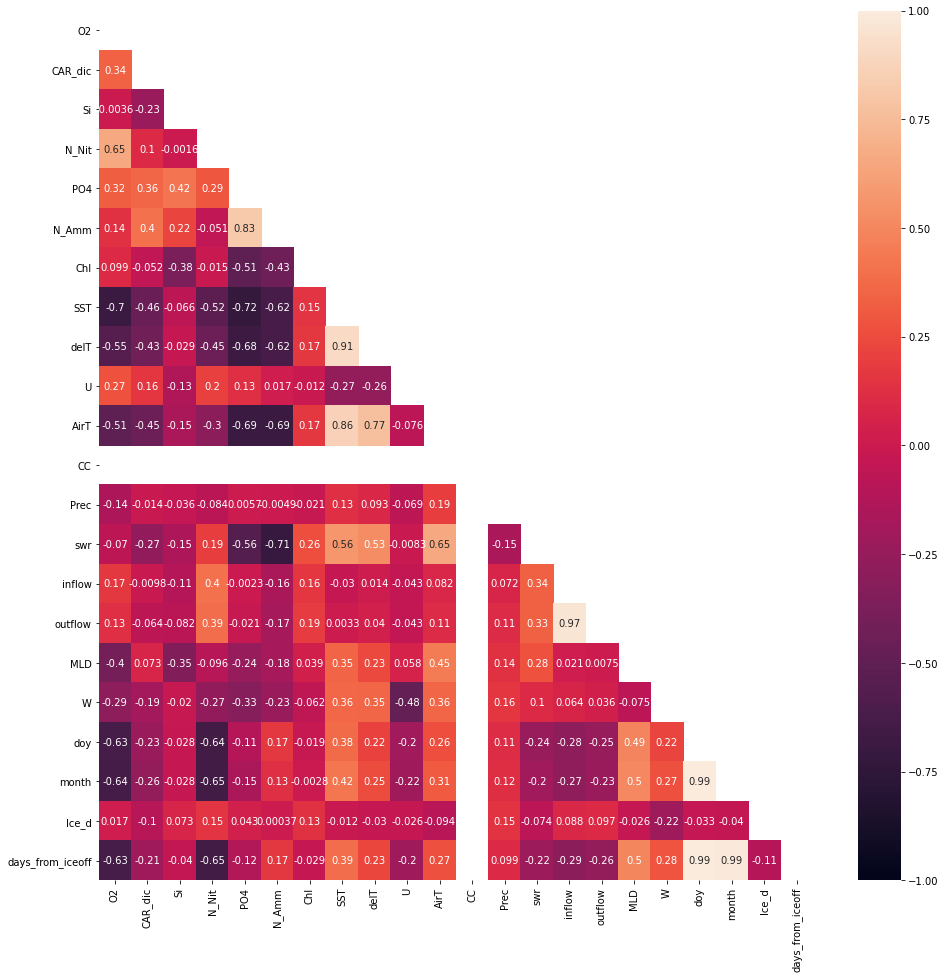

In [12]:
# Visualization of the correlations between features 
f,ax = plt.subplots(figsize = (16,16))
matrix = np.triu(all_df.corr())
sns.heatmap(all_df.corr(),vmin = -1, vmax = 1,annot = True,mask = matrix)

Target variable:O2
Training dataset evaluation:
RMSE 40.55 (+/- 11.87)
R2 0.70 (+/- 0.12)


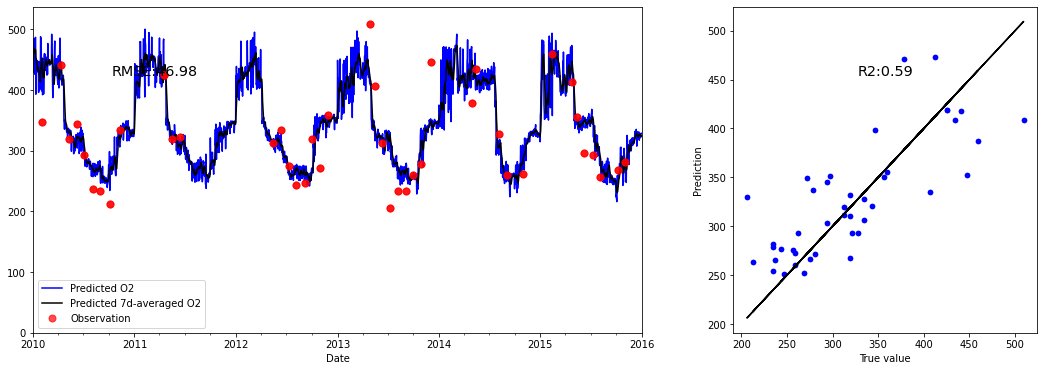

In [25]:
## Predict Nutrient 1
#Lake Erken: ['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
# 'Ice_d','days from iceoff','MLD','W','thermD']
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
#Erken_test = testing_daily_df[testing_daily_df['Date']>=plot_from]
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,target,test_time,ylim)
os.chdir('..\\Scenario2\\GBR')
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

Target variable:N_Nit
Training dataset evaluation:
RMSE 16.85 (+/- 6.92)
R2 0.32 (+/- 0.35)
Name of figure:ME_GBR_Nit


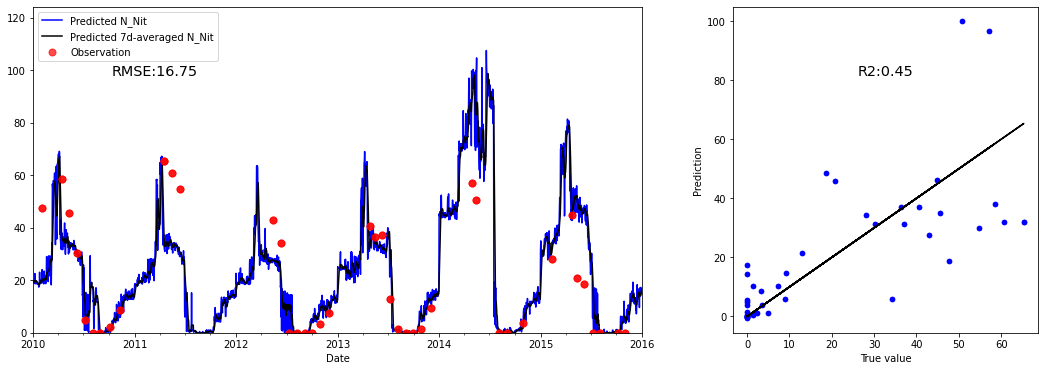

In [28]:
## Predict Nutrient 2
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2= predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

In [ ]:
## Predict Nutrient 3
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
# Lake Erken:['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
#            'Ice_d','days from iceoff','MLD','W','thermD',
#            'NOX(mmole/m3)','O2(mmole/m3)']

target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2= predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

Add extra features:
Target variable:PO4
Training dataset evaluation:
RMSE 0.85 (+/- 0.20)
R2 0.66 (+/- 0.19)
Name of figure:ME_GBR_PO4


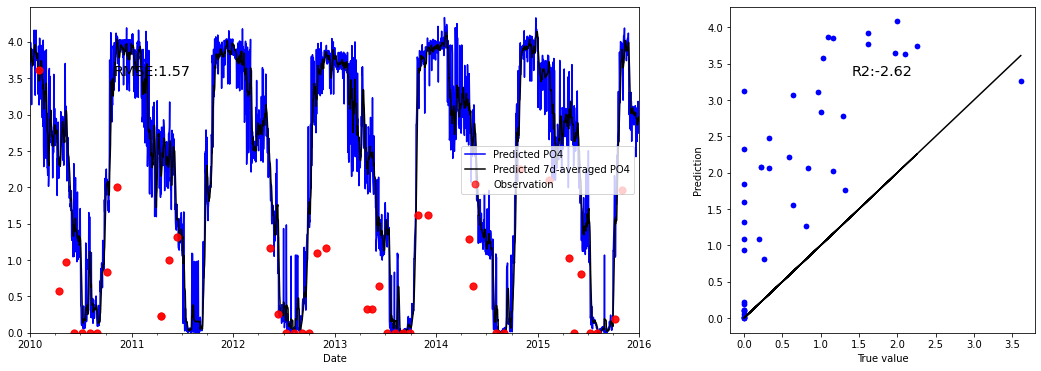

In [44]:
## Predict Nutrient 4
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
# Lake Erken:['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
#            'Ice_d','days from iceoff','MLD','W','thermD',
#            'NOX(mmole/m3)','O2(mmole/m3)']
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2  = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

Add extra features:
Target variable:Si
Training dataset evaluation:
RMSE 51.40 (+/- 12.20)
R2 -3.85 (+/- 4.64)
Name of figure:ME_GBR_Si


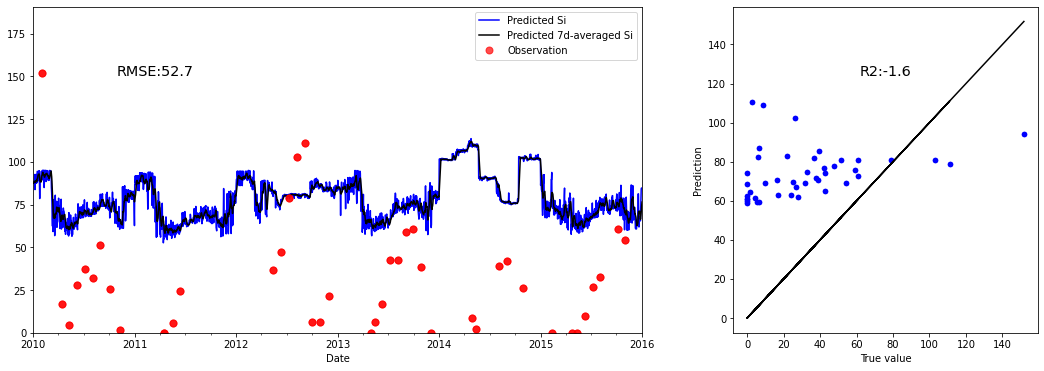

In [45]:
## Predict Nutrient 5
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
ylim = (0,all_df[target].max())
model = training_cv(all_df,features,target,year)
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

Add extra features:
Target variable:CAR_dic
Training dataset evaluation:
RMSE 430.27 (+/- 299.32)
R2 0.07 (+/- 0.39)
Name of figure:ME_GBR_CAR_dic


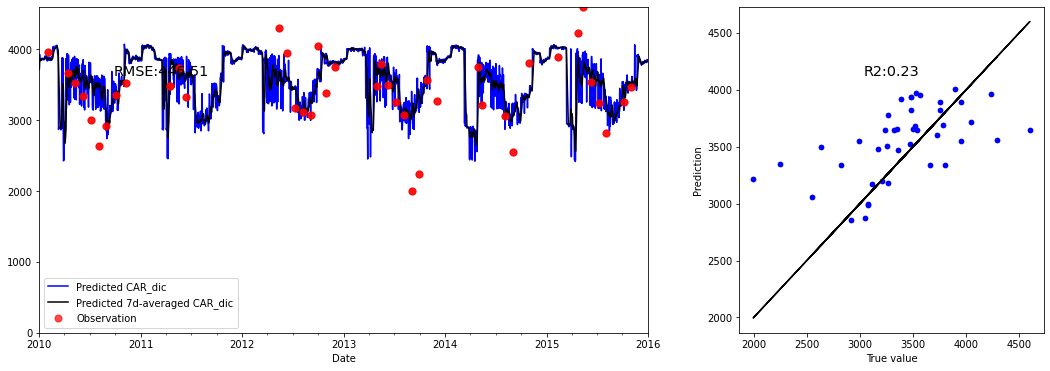

In [46]:
## Predict Nutrient 5
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
ylim = (0,all_df[target].max())
model = training_cv(all_df,features,target,year)
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

Add extra features:
Target variable:Chl
Training dataset evaluation:
RMSE 5.12 (+/- 1.29)
R2 0.19 (+/- 0.14)
Name of figure:ME_GBR_Chl


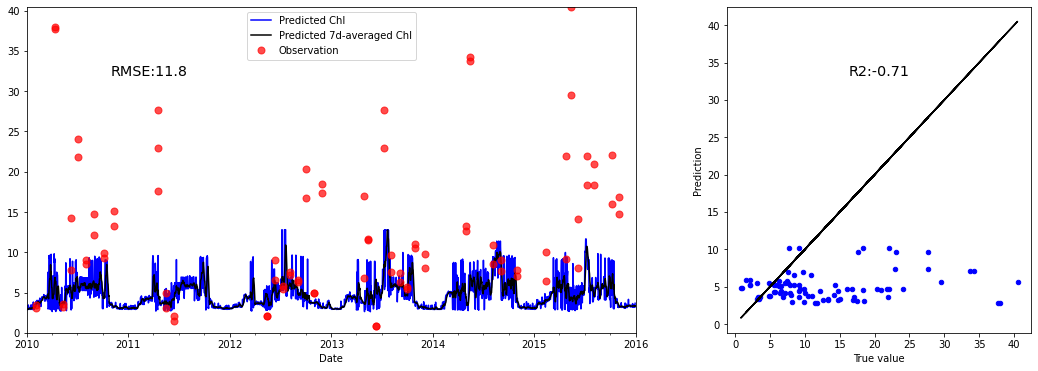

In [48]:
## Predict Chl via the same GBR method as the one used to pre-generate nutrients
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

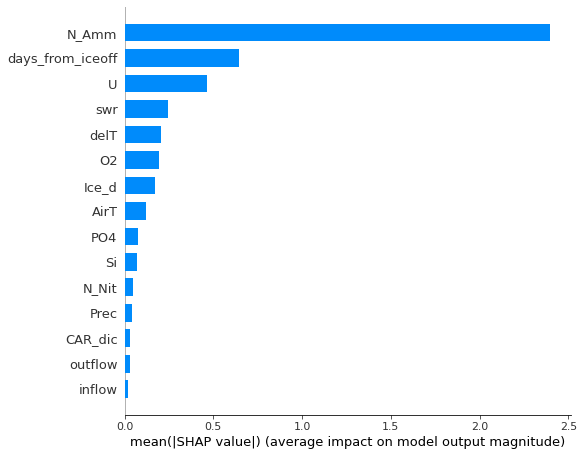

In [50]:
GBR = pickle.load(open('GBR.Chl.dat','rb'))
shap_values = shap.TreeExplainer(GBR).shap_values(Lake_Nut[features])
shap.summary_plot(shap_values,Lake_Nut[features],plot_type = 'bar',show=False)
plt.savefig('ME_Feature ranking.png')

In [51]:
Lake_Nut.to_csv('ME_GBR predicted nutrient and Chl.csv',index = False)

# LSTM model

In [91]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [92]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [93]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [104]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [95]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [96]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [97]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,date,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((date,pd.Timestamp(2021,2,1)))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [130]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [99]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [ ]:
n_batch,nb_epoch,n_neuros,dropout,time_steps,n_out,verbose,

In [123]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,date,hyperparameters,ylim):
    n_date = df[df['Date']<date]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,date,ylim)
    return model,RMSE,R2,figure

In [112]:
# set the directory
os.chdir('..\\LSTM')
# Create the daily df with Nan in nutrients columns
Nut = all_df[['Date','Si(mmole/m3)','TotP(mmole/m3)','NH4(mmole/m3)','NOX(mmole/m3)','PO4(mmole/m3)',
               'O2(mmole/m3)','Chl(mg/m3)']]
features = ['Date','month','U','SST','AirT','delT','Humidity','CC','swr(w/m2)','Prec(mm/d)','inflow(m3/s)',
           'Ice_d','days from iceoff','MLD','W','thermD']
testing_daily_df.drop('NOX(mmole/m3)',axis = 1,inplace = True)
Nut_memory = testing_daily_df.merge(Nut,how = 'left',on = 'Date')

In [117]:
# date to seperate training and test sets
date = pd.Timestamp(2017,1,1)

In [118]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':200,'dropout':0.1,'time_steps':7,'n_out':1,'verbose':0}

In [122]:
# predict NOX
nutrient = 'NOX(mmole/m3)'
# If add the features from process-based model, add features 'MLD','W','thermD'
var_name = ['delT', 'Ice_d','days from iceoff', 'inflow(m3/s)','U', 'AirT', 'Humidity', 'CC','swr(w/m2)', 
            'Prec(mm/d)','MLD','W','thermD', nutrient] # removed 'month' and 'SST' 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-1,24)
start_time = time.time()
NOX_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_NOX.png',dpi = 500)

In [131]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,NOX_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,NaN,NaN,NaN,10.105968,NaN,NaN,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,NaN,NaN,NaN,10.105968,NaN,NaN,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,NaN,NaN,NaN,10.105968,NaN,NaN,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,NaN,NaN,NaN,10.105968,NaN,NaN,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,NaN,NaN,NaN,10.105968,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,NaN,NaN,NaN,4.927908,NaN,NaN,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,NaN,NaN,NaN,4.969885,NaN,NaN,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,NaN,NaN,NaN,4.995772,NaN,NaN,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,NaN,NaN,NaN,5.004790,NaN,NaN,NaN


(2936, 8, 13) (2936,) (956, 8, 13) (956,)
number of input timesteps: 8
number of features: 13
number of samples: 364
Test RMSE: 34.17
Test R2: 0.70
Training dataset RMSE 29.94 (+/- 1.95)
Training dataset R2 0.72 (+/- 0.07)
Model takes 5 min to run


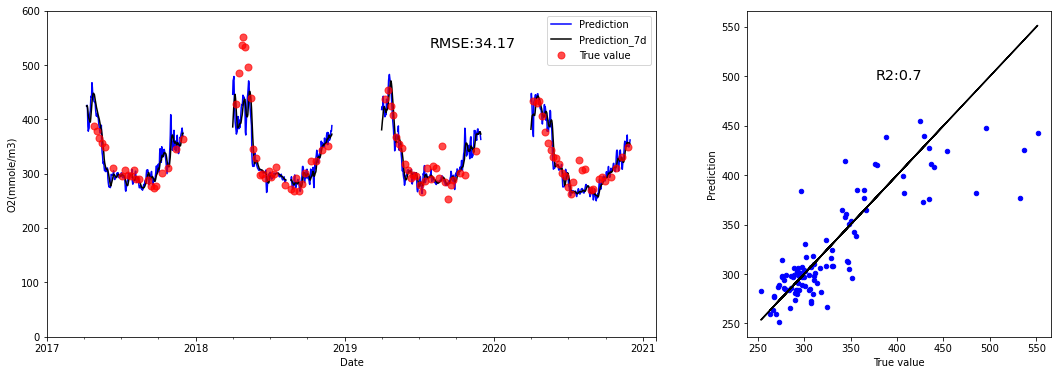

In [132]:
# predict O2
nutrient = 'O2(mmole/m3)'
var_name = ['delT', 'Ice_d','days from iceoff', 'inflow(m3/s)','U', 'AirT', 'Humidity', 'CC','swr(w/m2)', 
            'Prec(mm/d)','MLD','W','thermD',nutrient] # removed 'month' and 'SST'
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-0.5,600)
start_time = time.time()
O2_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_O2.png',dpi = 500)

In [133]:
Nut_memory = predict_ts(Nut_memory,nutrient,O2_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,NaN,NaN,NaN,10.105968,NaN,389.794525,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,NaN,NaN,NaN,10.105968,NaN,389.794525,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,NaN,NaN,NaN,10.105968,NaN,389.794525,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,NaN,NaN,NaN,10.105968,NaN,389.794525,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,NaN,NaN,NaN,10.105968,NaN,389.794525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,NaN,NaN,NaN,4.927908,NaN,351.520477,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,NaN,NaN,NaN,4.969885,NaN,348.881104,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,NaN,NaN,NaN,4.995772,NaN,355.609894,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,NaN,NaN,NaN,5.004790,NaN,356.462799,NaN


(2936, 8, 15) (2936,) (956, 8, 15) (956,)
number of input timesteps: 8
number of features: 15
number of samples: 364
Test RMSE: 0.68
Test R2: 0.18
Training dataset RMSE 1.00 (+/- 0.24)
Training dataset R2 -0.30 (+/- 0.75)
Model takes 5 min to run


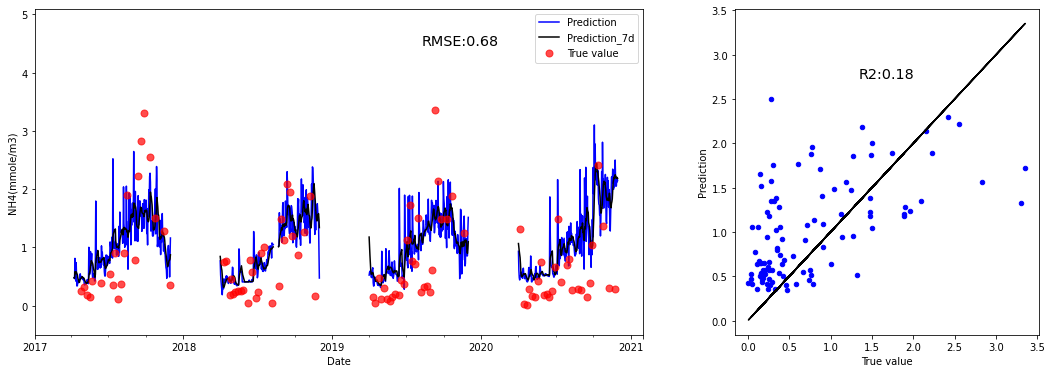

In [134]:
#predict NH4
nutrient = 'NH4(mmole/m3)'
var_name = ['delT', 'Ice_d','days from iceoff', 'inflow(m3/s)','U', 'AirT', 'Humidity', 'CC','swr(w/m2)', 
            'Prec(mm/d)','NOX(mmole/m3)','O2(mmole/m3)','MLD','W','thermD',nutrient] 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-0.5,5.1)
start_time = time.time()
NH4_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_NH4.png',dpi = 500)

In [135]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,NH4_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,NaN,NaN,0.445100,10.105968,NaN,389.794525,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,NaN,NaN,0.445100,10.105968,NaN,389.794525,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,NaN,NaN,0.445100,10.105968,NaN,389.794525,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,NaN,NaN,0.445100,10.105968,NaN,389.794525,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,NaN,NaN,0.445100,10.105968,NaN,389.794525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,NaN,NaN,2.050583,4.927908,NaN,351.520477,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,NaN,NaN,2.055912,4.969885,NaN,348.881104,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,NaN,NaN,2.194375,4.995772,NaN,355.609894,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,NaN,NaN,2.125913,5.004790,NaN,356.462799,NaN


(2936, 8, 15) (2936,) (956, 8, 15) (956,)
number of input timesteps: 8
number of features: 15
number of samples: 364
Test RMSE: 0.23
Test R2: 0.70
Training dataset RMSE 0.22 (+/- 0.06)
Training dataset R2 0.72 (+/- 0.13)
Model takes 5 min to run


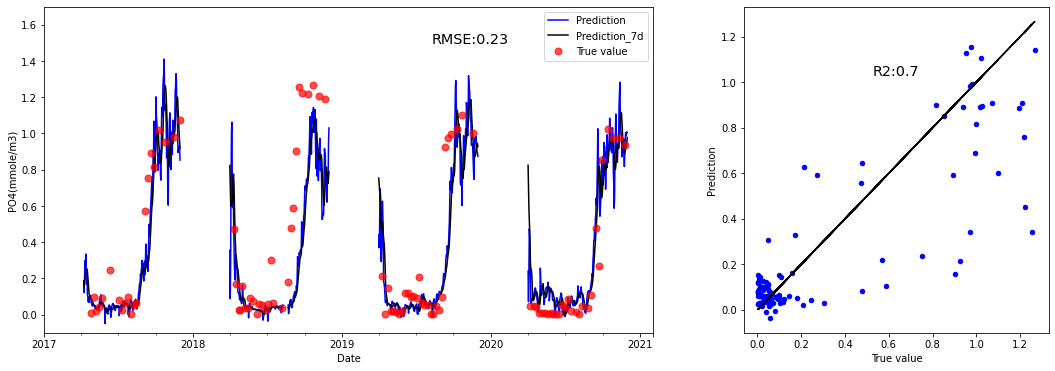

In [136]:
# Predict PO4
nutrient = 'PO4(mmole/m3)'
var_name = ['delT', 'Ice_d','days from iceoff', 'inflow(m3/s)','U', 'AirT', 'Humidity', 'CC','swr(w/m2)', 
            'Prec(mm/d)','NOX(mmole/m3)','O2(mmole/m3)','MLD','W','thermD', nutrient] 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-0.1,1.7)
start_time = time.time()
PO4_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_PO4.png',dpi = 500)

In [137]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,PO4_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,NaN,NaN,0.445100,10.105968,0.349131,389.794525,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,NaN,NaN,0.445100,10.105968,0.349131,389.794525,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,NaN,NaN,0.445100,10.105968,0.349131,389.794525,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,NaN,NaN,0.445100,10.105968,0.349131,389.794525,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,NaN,NaN,0.445100,10.105968,0.349131,389.794525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,NaN,NaN,2.050583,4.927908,1.004589,351.520477,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,NaN,NaN,2.055912,4.969885,0.985875,348.881104,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,NaN,NaN,2.194375,4.995772,0.995873,355.609894,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,NaN,NaN,2.125913,5.004790,1.008634,356.462799,NaN


(2936, 8, 16) (2936,) (956, 8, 16) (956,)
number of input timesteps: 8
number of features: 16
number of samples: 364
Test RMSE: 0.31
Test R2: 0.46
Training dataset RMSE 0.28 (+/- 0.04)
Training dataset R2 0.54 (+/- 0.10)
Model takes 5 min to run


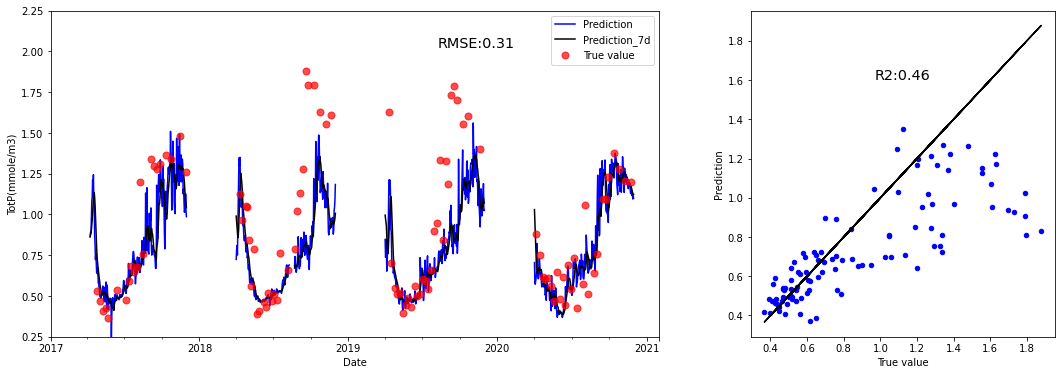

In [138]:
# Predict TP
nutrient = 'TotP(mmole/m3)'
var_name = ['delT', 'Ice_d','days from iceoff','inflow(m3/s)','U','AirT','Humidity','CC','swr(w/m2)', 
            'Prec(mm/d)','NOX(mmole/m3)','PO4(mmole/m3)','O2(mmole/m3)', 'MLD','W','thermD',nutrient] 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (0.25,2.25)
start_time = time.time()
TP_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig('LSTM_TP.png',dpi = 500)

In [139]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,TP_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,NaN,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,NaN,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,NaN,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,NaN,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,NaN,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,NaN,1.117330,2.050583,4.927908,1.004589,351.520477,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,NaN,1.130188,2.055912,4.969885,0.985875,348.881104,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,NaN,1.094798,2.194375,4.995772,0.995873,355.609894,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,NaN,1.114076,2.125913,5.004790,1.008634,356.462799,NaN


(2936, 8, 16) (2936,) (956, 8, 16) (956,)
number of input timesteps: 8
number of features: 16
number of samples: 364
Test RMSE: 25.68
Test R2: -1.93
Training dataset RMSE 20.44 (+/- 1.46)
Training dataset R2 0.06 (+/- 0.10)
Model takes 5 min to run


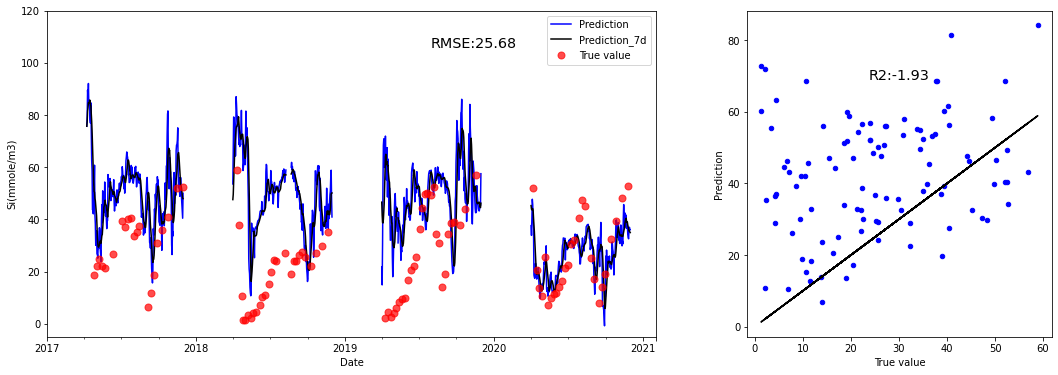

In [140]:
# Predict Si
nutrient = 'Si(mmole/m3)'
var_name = ['delT', 'Ice_d','days from iceoff','inflow(m3/s)','U','AirT','Humidity','CC','swr(w/m2)', 
            'Prec(mm/d)','NOX(mmole/m3)','PO4(mmole/m3)','O2(mmole/m3)', 'MLD','W','thermD',nutrient] 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-5,120)
start_time = time.time()
Si_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

figure.savefig('LSTM_Si.png',dpi = 500)

In [141]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Si_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,month,U,SST,AirT,delT,Humidity,CC,swr(w/m2),Prec(mm/d),inflow(m3/s),Ice_d,days from iceoff,MLD,thermD,W,Si(mmole/m3),TotP(mmole/m3),NH4(mmole/m3),NOX(mmole/m3),PO4(mmole/m3),O2(mmole/m3),Chl(mg/m3)
0,2004-04-01,4,3.190208,2.618000,-0.699167,0.060540,67.166667,0.075000,621.50,0.0,2.547,106,-13.0,-21.0,-15.0,0.015696,70.427734,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
1,2004-04-02,4,2.329375,2.745480,-1.309583,0.167350,70.458333,0.000000,628.30,0.0,2.351,106,-12.0,-21.0,-15.0,0.032220,70.427734,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
2,2004-04-03,4,3.508792,2.874505,0.827083,0.218715,68.166667,0.016667,625.40,0.0,2.174,106,-11.0,-21.0,-15.0,0.074359,70.427734,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
3,2004-04-04,4,3.748208,3.043310,2.724167,0.328140,74.875000,0.808333,432.30,2.7,2.014,106,-10.0,-21.0,-15.0,0.024685,70.427734,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
4,2004-04-05,4,1.808667,3.140605,3.900417,0.383935,84.958333,0.975000,633.20,0.0,1.870,106,-9.0,-21.0,-15.0,0.005891,70.427734,0.896956,0.445100,10.105968,0.349131,389.794525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,2020-11-26,11,3.321292,6.295317,5.930417,0.111327,98.125000,0.845833,31.39,0.0,0.779,5,291.0,-21.0,-15.0,0.002728,32.563267,1.117330,2.050583,4.927908,1.004589,351.520477,NaN
3895,2020-11-27,11,4.360500,6.281413,2.672083,0.063770,92.695833,0.945833,57.70,0.4,0.781,5,292.0,-21.0,-15.0,0.014944,35.691750,1.130188,2.055912,4.969885,0.985875,348.881104,NaN
3896,2020-11-28,11,2.387167,6.149032,1.992500,-0.006724,92.887500,1.000000,52.75,0.2,0.773,5,293.0,-21.0,-15.0,0.002919,36.981392,1.094798,2.194375,4.995772,0.995873,355.609894,NaN
3897,2020-11-29,11,2.114958,6.034864,0.251667,0.045284,99.500000,1.000000,32.69,0.7,0.789,5,294.0,-21.0,-15.0,0.028674,36.006802,1.114076,2.125913,5.004790,1.008634,356.462799,NaN


(2936, 8, 19) (2936,) (956, 8, 19) (956,)
number of input timesteps: 8
number of features: 19
number of samples: 364
Test RMSE: 5.55
Test R2: 0.22
Training dataset RMSE 4.15 (+/- 0.36)
Training dataset R2 0.37 (+/- 0.11)
Model takes 5 min to run


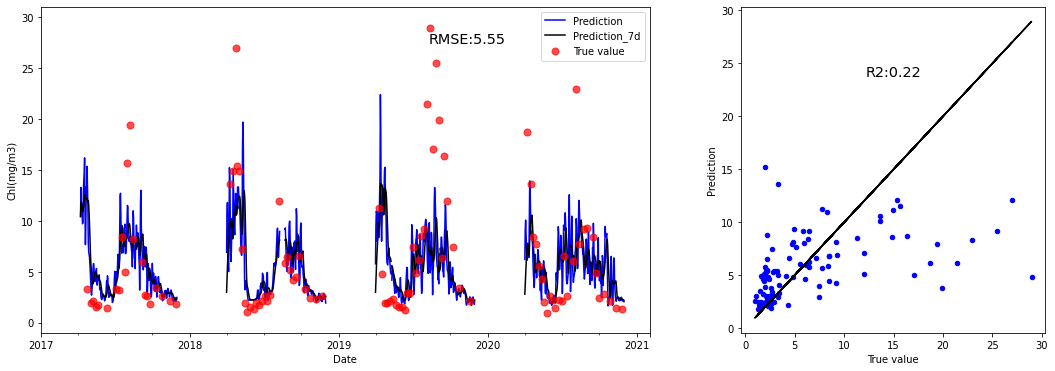

In [142]:
# Predict Chl
nutrient = 'Chl(mg/m3)'
var_name = ['delT', 'Ice_d','days from iceoff','inflow(m3/s)','U','AirT','Humidity','CC','swr(w/m2)', 
            'Prec(mm/d)','NOX(mmole/m3)','PO4(mmole/m3)','Si(mmole/m3)', 'TotP(mmole/m3)','NH4(mmole/m3)','O2(mmole/m3)', 
            'MLD','W','thermD',nutrient] 
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (-1,31)
start_time = time.time()
Chl_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,date,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

figure.savefig('LSTM_Chl.png',dpi = 500)

In [143]:
# use the trained model to interplate the whole timeseriestime_steps,n_out,verbose
Nut_memory = predict_ts(Nut_memory,nutrient,Chl_model,hyperparameters,values)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [144]:
Nut_memory.to_csv('LSTM predicted nutrient and Chl data.csv',index = False)